In [1]:
# Import dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d

import random

### Function Implementation
The Schwefel function is a continuous, multimodal, non-convex, deceptive (many local optima), and N-dimensional function with a global minimum of 0.

> $f_{schwefel}(x_1, x_2, ... x_N) = 418.98291 N - \sum_{i=1}^N x_i sin(\sqrt {|x_i|})$

It takes in N random numbers in a pre-defined range, processes them through the formula above, and returns a value. For example, if $N = 2$, we might randomly generate numbers $x_1 = 0$ and $x_2 = 0$, plug them into the Schwefel function, and get a value of 837.96582.

### Genetic Algorithm Goal
The goal of this project is to build a Genetic Algorithm such that, for some given number range for N random numbers, we can find a combination of N numbers to yield a value of 0 or close to 0 when inputted into our Schwefel function.

In [2]:
def schwefel(num_list):  
    return (418.98291*len(num_list)) - np.sum([x*np.sin(np.sqrt(np.absolute(x)))for x in num_list])

In [3]:
schwefel([0,0])

837.96582

Due to floating point errors, we can't *really* hit 0 consistently as `np.sin(np.pi)` yields $1.22\times10^{-16}$ where it should be 0. The value is, however, small enough to be negligible in the grand scheme of things, though.

In [4]:
schwefel([420.969 for i in range(10)])

0.00022735684069630224

Note, with a little bit of math, you can quickly find one of the solutions as all of the numbers you input into the Schwefel function is arbitrary. You can practically solve it by graphing these two equations on Desmos or whatever graphing calculator software you have.
> $y = 418.98291$

> $y = sin(\sqrt {|x_i|})$

### Quick Visualization
We can plot the full extent of the Schwefel function's range for $N = 2$ by plotting the Schwefel function value of every combination of those two numbers onto a third axis to make a 3-Dimensional visualization of the Schwefel fitness landscape.

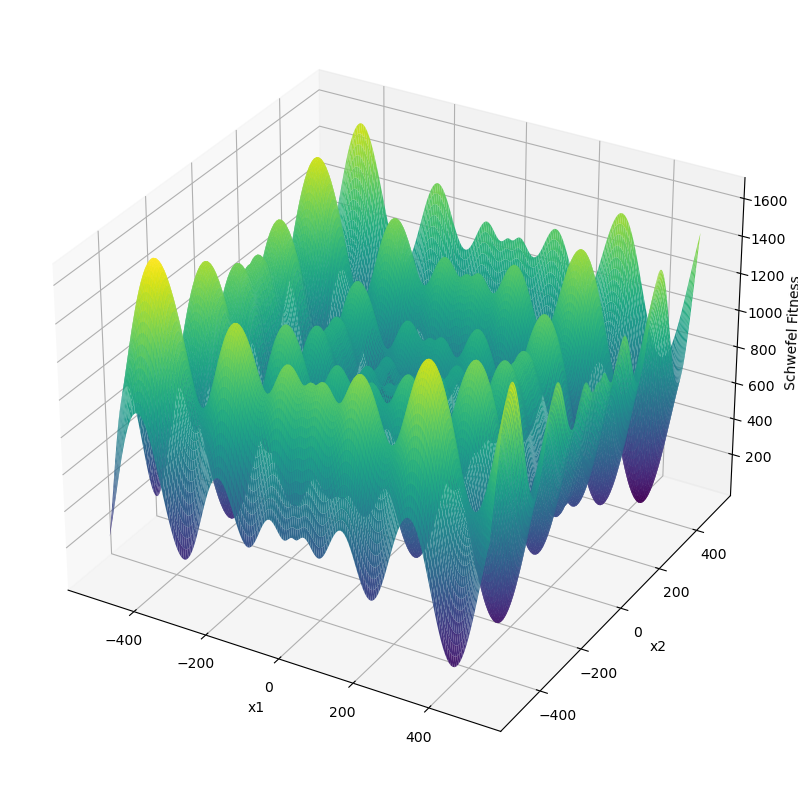

In [5]:
# Visualization of 2-Dimensional Schwefel function (3-D Fitness landscape visualization)
# Schwefel function modified for graphing convenience
def schwefel2(x, y):  
    return (418.98291*2) - ((x*np.sin(np.sqrt(np.absolute(x))))+(y*np.sin(np.sqrt(np.absolute(y)))))

x1 = np.linspace(-512, 512, 200)
x2 = np.linspace(-512, 512, 200)

X1, X2 = np.meshgrid(x1, x2)
results = schwefel2(X1, X2)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X1, X2, results, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Schwefel Fitness')
plt.show()

## Real-Valued GA Approach
- Representation and Population: 100 randomly generated lists of 10 real numbers.
- Parents selected via Tournament Selection (n=2)
- Crossover (Pc = 0.9): Uniform, Whole Arithmetic
- Mutation (Pm = 1/10 = 0.1): Uniform
- Survivor Selection: Parents+Offspring
- Run for 500 generations and see how close we get.

In [6]:
# Population Init for 100 randomly generated genotypes
population = [[random.uniform(-512, 512) for i in range(10)] for i in range(100)]

# This line sorts our population by the values of its schwefel fitness value
population.sort(key=schwefel)
# Access scores via [schwefel(i) for i in population]

In [7]:
# Mutation Operator - Mutating each number in a chromosome by drawing from a range of [x-creep, x+creep]
# Maxs and Mins used to make sure the numbers don't go out of bounds.

# Toggle parameters here (e.g.: creep = +-128 to cover 25% of possible number range)
creep = 128
mrate = 0.1 # Per bit

# Takes in one chromosome and mutates each gene
def mutate(geno):
    return [random.uniform(max(-512, i-creep), min(512, i+creep)) if(random.uniform(0,1)<=mrate) else i for i in geno]
# Mutate with [mutate(i) for i in population]

In [8]:
# Crossover Operator - Taking 2 chromosomes and doing uniform whole arithmetic recombination

# Uniform, so crossover parameter is 0.5. Takes equal influence from both parents, returns identical children
alpha = 0.5
xrate = 0.9 # Per crossover operation, else copy parents

# Takes in two chromosomes and returns two new chromosomes
def cross(geno1, geno2):
    if(random.uniform(0,1)<=xrate):
        child1 = [alpha*geno1[i]+(1-alpha)*geno2[i] for i in range(len(geno1))]
        child2 = [alpha*geno2[i]+(1-alpha)*geno1[i] for i in range(len(geno2))]
        return [child1, child2]
    return [geno1, geno2]
# Add to population with population+cross(a,b)

In [9]:
# Parent Selector - Tournament selection. Tournament participants are uniformly random, selection within is rank-based
# Contestants picked without replacement, n = tournament size, replaced after tournament
n = 2

# Linear ranking parameters
s = 1.5


def parent_sel(population):
    # Cumulative sum of ranking probabilities used here for random choice selection
    rcsum = np.cumsum([(((2-s)/n)+((2*(n-i-1)*(s-1))/(n*(n-1))))for i in range(n)])
    parents = []
    
    # Repeat process twice to get 2 parents for reproduction
    for i in range(2):
        # Set up copy for easier management
        copy_pool = population.copy()
        
        # Pick n contestants without replacement and sort by fitness    
        tourn_pool = [copy_pool.pop(random.randint(0, len(copy_pool)-1)) for i in range(n)]
        tourn_pool.sort(key=schwefel)
        
        # Pick based on rank weights
        a = random.choices(tourn_pool, cum_weights=rcsum, k=1)
        parents = parents+a

    return parents
# Have crossover call with cross(*parents)

In [10]:
# Survival Selector - Parents and Offsprings competing together
psize = 100

# Deterministic selection: Just picks Top 100 by dropping the worst (highest fitness) instead of sorting the list
def det_surv(pop):
    for i in range(len(pop)-psize):
        pop.remove(max(pop, key=schwefel))
    return pop

# Stochastic selection: Semi-randomly pick survivors

In [11]:
# Initialize population
population = [[random.uniform(-512, 512) for i in range(10)] for i in range(100)]

# Keep track of both fitness over time and best performer overtime
# Doing range(501) here because we're also counting its initial performance
gen = [i for i in range(501)]
f_progress = [min([schwefel(i) for i in population])]
b_progress = [min(population, key=schwefel)]

for i in range(500):
    # Parent Selection
    parents = parent_sel(population)
    
    # Variation Operators
    children = cross(*parents)
    children = [mutate(i) for i in children]
    
    # Survival Selection
    population = det_surv(population+children)
    
    f_progress.append(min([schwefel(i) for i in population]))
    b_progress.append(min(population, key=schwefel))


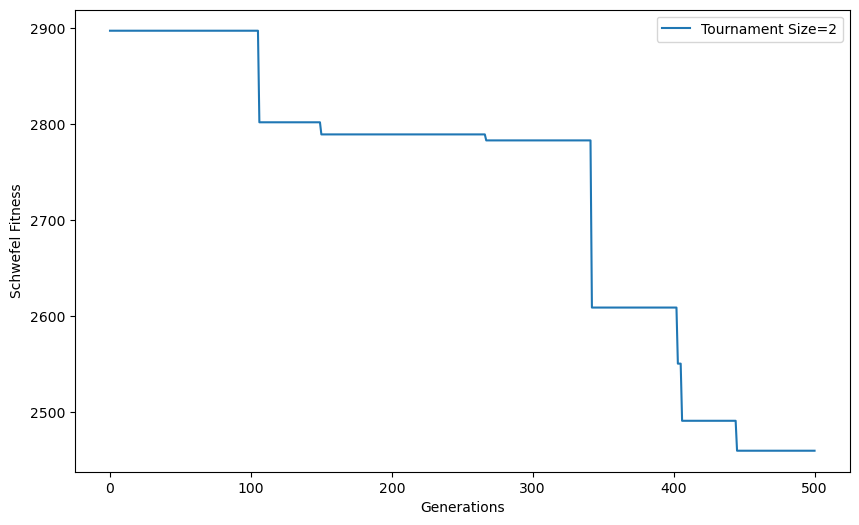

In [12]:
plt.rcParams['figure.figsize'] = [10,6]

plt.plot(gen, f_progress, label=f"Tournament Size={n}")
plt.xlabel("Generations")
plt.ylabel("Schwefel Fitness")
plt.legend()
plt.show()

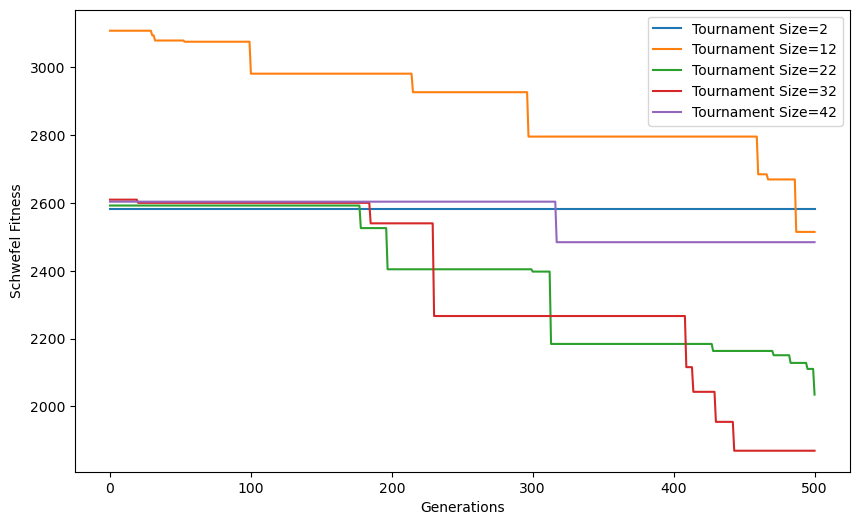

In [13]:
# This time, with varying Tournament Sizes
for tsize in range(2, 52, 10):
    n = tsize
    # Initialize population
    population = [[random.uniform(-512, 512) for i in range(10)] for i in range(100)]

    # Keep track of both fitness over time and best performer overtime
    # Doing range(501) here because we're also counting its initial performance
    gen = [i for i in range(501)]
    f_progress = [min([schwefel(i) for i in population])]
    b_progress = [min(population, key=schwefel)]

    for i in range(500):
        # Parent Selection
        parents = parent_sel(population)

        # Variation Operators
        children = cross(*parents)
        children = [mutate(i) for i in children]

        # Survival Selection
        population = det_surv(population+children)

        f_progress.append(min([schwefel(i) for i in population]))
        b_progress.append(min(population, key=schwefel))
    plt.plot(gen, f_progress, label=f"Tournament Size={n}")
plt.xlabel("Generations")
plt.ylabel("Schwefel Fitness")
plt.legend()
plt.show()
n=2

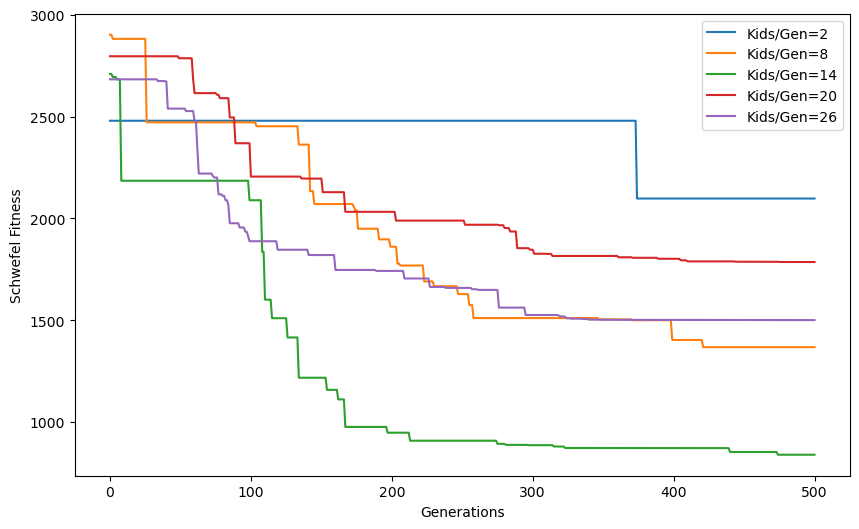

In [14]:
# This time, with varying number of kids/generation
# Each crossover makes 2 kids, so we can repeat that 15 times to make 30 kids
for kids in range(1, 16, 3):
    # Initialize population
    population = [[random.uniform(-512, 512) for i in range(10)] for i in range(100)]

    # Keep track of both fitness over time and best performer overtime
    # Doing range(501) here because we're also counting its initial performance
    gen = [i for i in range(501)]
    f_progress = [min([schwefel(i) for i in population])]
    b_progress = [min(population, key=schwefel)]

    for i in range(500):
        for i in range(kids):
            # Parent Selection
            parents = parent_sel(population)

            # Variation Operators
            children = cross(*parents)
            children = [mutate(i) for i in children]
            population = population+children

        # Survival Selection
        population = det_surv(population)

        f_progress.append(min([schwefel(i) for i in population]))
        b_progress.append(min(population, key=schwefel))
    plt.plot(gen, f_progress, label=f"Kids/Gen={2*kids}")
plt.xlabel("Generations")
plt.ylabel("Schwefel Fitness")
plt.legend()
plt.show()

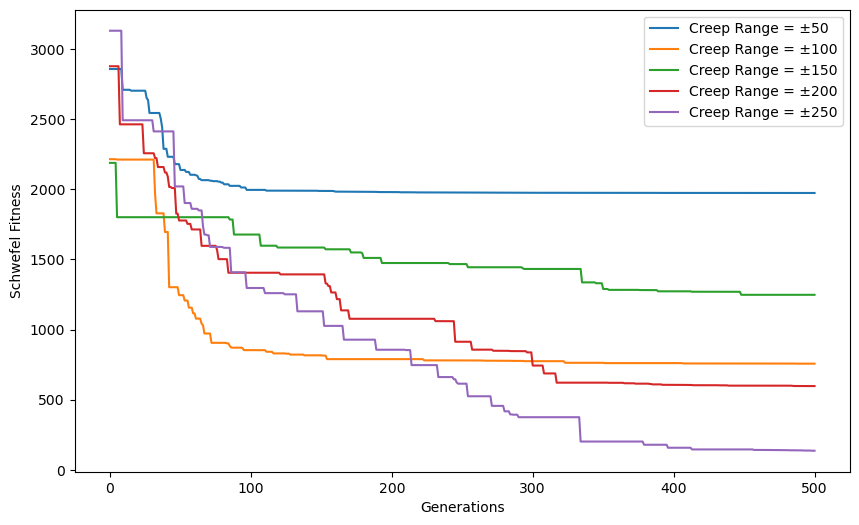

In [19]:
# This time, with varying mutation creep
# Setting each generation to have 30 kids
for w in range(1,6):
    creep = w*50
    # Initialize population
    population = [[random.uniform(-512, 512) for i in range(10)] for i in range(100)]

    # Keep track of both fitness over time and best performer overtime
    # Doing range(501) here because we're also counting its initial performance
    gen = [i for i in range(501)]
    f_progress = [min([schwefel(i) for i in population])]
    b_progress = [min(population, key=schwefel)]

    for i in range(500):
        for i in range(16):
            # Parent Selection
            parents = parent_sel(population)

            # Variation Operators
            children = cross(*parents)
            children = [mutate(i) for i in children]
            population = population+children

        # Survival Selection
        population = det_surv(population)

        f_progress.append(min([schwefel(i) for i in population]))
        b_progress.append(min(population, key=schwefel))
    plt.plot(gen, f_progress, label=f"Creep Range = ±{creep}")
plt.xlabel("Generations")
plt.ylabel("Schwefel Fitness")
plt.legend()
plt.show()

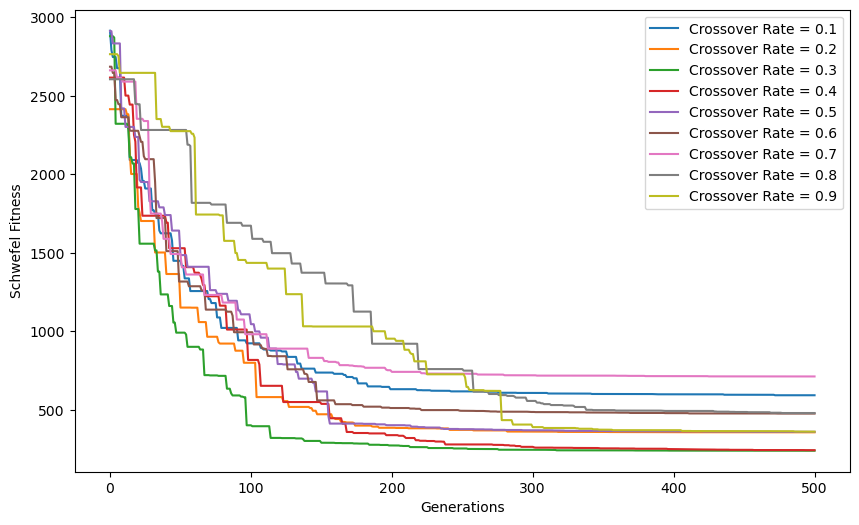

In [20]:
# This time, with varying Crossover Rate
# Setting each generation to have 30 kids and a creep range of ±256
creep = 256

for w in range(1,10):
    xrate = w/10
    # Initialize population
    population = [[random.uniform(-512, 512) for i in range(10)] for i in range(100)]

    # Keep track of both fitness over time and best performer overtime
    # Doing range(501) here because we're also counting its initial performance
    gen = [i for i in range(501)]
    f_progress = [min([schwefel(i) for i in population])]

    for i in range(500):
        for i in range(16):
            # Parent Selection
            parents = parent_sel(population)

            # Variation Operators
            children = cross(*parents)
            children = [mutate(i) for i in children]
            population = population+children

        # Survival Selection
        population = det_surv(population)

        f_progress.append(min([schwefel(i) for i in population]))
    plt.plot(gen, f_progress, label=f"Crossover Rate = {xrate}")
plt.xlabel("Generations")
plt.ylabel("Schwefel Fitness")
plt.legend()
plt.show()

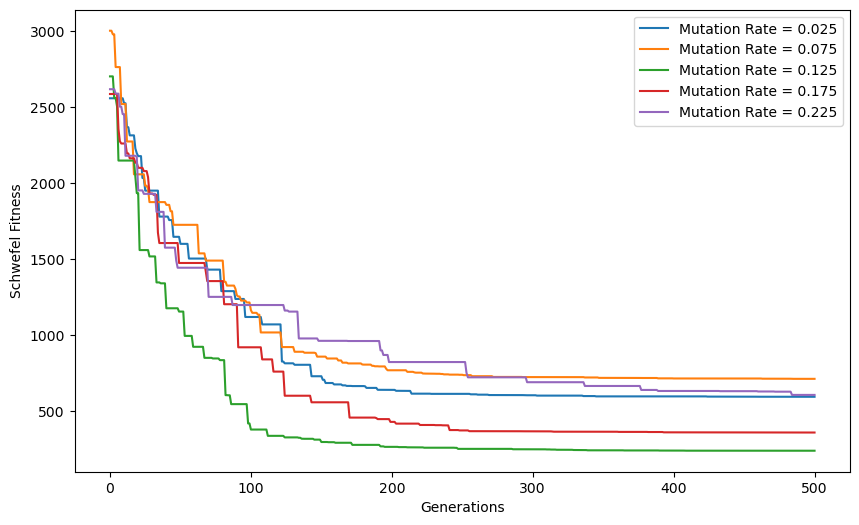

In [21]:
# This time, with varying Mutation Rate
# Setting each generation to have 30 kids, tournament size of 30, creep range of ±256, and crossover rate of 0.3
n = 30
creep = 256
xrate = 0.3

for w in range(1,11,2):
    mrate = w/40
    # Initialize population
    population = [[random.uniform(-512, 512) for i in range(10)] for i in range(100)]

    # Keep track of both fitness over time and best performer overtime
    # Doing range(501) here because we're also counting its initial performance
    gen = [i for i in range(501)]
    f_progress = [min([schwefel(i) for i in population])]

    for i in range(500):
        for i in range(16):
            # Parent Selection
            parents = parent_sel(population)

            # Variation Operators
            children = cross(*parents)
            children = [mutate(i) for i in children]
            population = population+children

        # Survival Selection
        population = det_surv(population)

        f_progress.append(min([schwefel(i) for i in population]))
    plt.plot(gen, f_progress, label=f"Mutation Rate = {mrate}")
plt.xlabel("Generations")
plt.ylabel("Schwefel Fitness")
plt.legend()
plt.show()

## Binary GA Approach
- Representation and Population: 100 randomly generated lists of 10 binary numbers.
- Parents selected via Tournament Selection (n=2)
- Crossover (Pc = 0.9): Uniform, 2-Point
- Mutation (Pm = 1/100 = 0.01): Bit-flip
- Survivor Selection: Parents+Offspring
- Run for 500 generations and see how close we get.

In [15]:
# TODO: Pop init, cross, mutate, parent sel, survivor sel, terminate

In [16]:
a = '-'+''.join(str(random.randint(0, 1)) for i in range(9))

In [17]:
a

'-100101000'

In [18]:
int(a)

-100101000